### Nicolas Maurer - Thomas Gerberon  $ \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ *Algorithmes Stochastiques*

## $\;$


# <center> Circuit automobile </center> 



## Objectifs :
- Vérifier l'éxistence de la limite du flux moyen
- Simuler l'évolution de **n** véhicules sur un circuit de course de taille **N**.
- Etudier le flux moyen en fonction de la proportion $\rho$ des véhicules dans le circuit.
- Proposer une fonction polynomiale qui approxime le flux moyen
- Faire les objectifs précédent pour un modèle avec et sans dépassement

## Paramètres :
- Circuit automobile découpé en **N** cases avec un véhicule par case au maximum.
- **n** véhicules avec **1 <math>≤</math> n <math>≤</math> N.**
- Chaque véhicule possède une horloge interne indépendante entre elles.
- Le k-ème tic d'une horloge se produit à l'instant $T_{k}$ = $\sum_{i=1}^k\Delta_{i}$ où les $\Delta_{i}$ sont des variables aléatoire de loi $ E(1)$
- Taux de remplissage du circuit : $\rho = n / N$
- Flux moyen : $ \Gamma = \lim\limits_{t\rightarrow\ + \infty} \Gamma_{T} /t $

## Plan : 


### Initialisation :

- Création du circuit  
- Mise en plage des horloges et de l'ordre de déplacement  

### Modèle sans dépassement :

- Déplacement des voitures et calcul du flux
- Représentations visuel d'une course
- Représentation du flux et interprétations

### Modèle avec dépassement :

- Déplacement des voitures et calcul du flux
- Représentations visuel d'une course
- Représentation du flux et interprétations

### Optimisation des fonctions :
- Quelques détails supplémentaires
- Temps d'éxécution total 

## Librairies utilisées

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from numpy.random import rand, randint, seed, exponential, shuffle
import time

## Paramètres de notre modèle 

Pour la cohérence de l'étude on a choisit de prendre une course de $100$ cases ainsi que $10$ voitures que l'on palcera aléatoirement.  
La proportion de remplissage de la course est donc de $0.02 = 2 \% $

L'horloge de chaque voitures sonnera $10 000$ fois, ce permettra aux de voitures de faire au maximum $20$ tours.

In [2]:
seed(14) # Reproductibilité 
temps_total = time.time()
N = 500  # Nombre de cases pour le circuit.
n = 10 # Nombre de véhicules dans le circuit.
k = 10000 # Nombre de tics pour chaque horloges de chaque voitures.

## Création du circuit

On commence par créer un circuit, où chaque voiture sera positionné aléatoirement dessus.

Pour optimiser le fonctionnement de nos programmes, la fonction renverra aussi l'emplacement des véhicules dans la course.

In [3]:
def circuit(N,n):

    """ 
    Paramètres :
    - N = nombre de cases 
    - n = nombre de véhicules
        
    Output :
    - Etat initial du circuit avec les voitures placé dessus
    - Emplacement des voitures dans le circuit.
    """

    circuit = np.zeros(N,dtype=int) # Liste des cases vides
    emplacement_voiture = np.zeros(n,dtype=int)
    
    numero_vehicule = np.arange(1,n+1)
    liste_cases = np.arange(1,N)
    liste_cases_aleatoire = np.copy(liste_cases)  # crée une copy de la liste des cases
    shuffle(liste_cases_aleatoire) # mélange la liste des cases
    
    for i in range(n):
        circuit[liste_cases_aleatoire[i]] = numero_vehicule[i]  # place les voitures sur les cases aléatoires
        emplacement_voiture[i] = liste_cases_aleatoire[i]
    return circuit,emplacement_voiture

In [4]:
# Test d'une petite course 
etat_ini = circuit(20,10)
print("Exemple d'un petit circuit à l'instant 0 : \n" ,etat_ini[0])
print("Emplacement des voitures dans ce circuit :\n", etat_ini[1])

Exemple d'un petit circuit à l'instant 0 : 
 [ 0  0  4  3  7  5  2  0  0 10  0  0  0  0  0  8  1  9  0  6]
Emplacement des voitures dans ce circuit :
 [16  6  3  2  5 19  4 15 17  9]


## Initialisation Horloges et des ordres des voitures à essayer de déplacer

Le but de cette fonction est de trouver qu'elle sera l'ordre des voitures a éssayer de déplacer.  

On explique le fonctionement de la fonction sur la cellule d'en dessous celle-ci.

In [5]:
def ordre_deplacement(n,k):
    
    """
    Paramètres : 
    - n = nombre de véhicules
    - k = nombre de tics par véhicule
        
    Output :
    - Ordre des voitures à essayer de déplacer 
    """
    
    horloges = np.zeros((n,k))

    for i in range(n):
        horloges[i,:] = np.cumsum(exponential(1,k)) # Initie les horloges de chaque véhicules 


    vecteur_horloges = np.copy(horloges)
    vecteur_horloges = np.reshape(vecteur_horloges,[1,n*k]) # on le transforme en un vecteur ligne

    indices = sorted(range(len(vecteur_horloges[0])), key = lambda k: vecteur_horloges[0][k])
    # Renvoie le vecteur des indices triés selon les valeurs du vecteur 
    
    
    deplacement = np.zeros(n*k,dtype=int)
    for i in range(len(indices)):
        deplacement[i] = indices[i] // k + 1 # On rajoute + 1 car les indices des voitures commencent à 1  
    return deplacement

In [6]:
#Test
print(" Ordre des voitures à essayer de déplacer : \n", ordre_deplacement(n,k))

 Ordre des voitures à essayer de déplacer : 
 [2 4 4 ... 6 6 4]


## Explications de l'algorithme ordre_deplacement

Les valeurs créent ci-dessous servent uniquement à la compréhension de l'algorithme.  
Ici $n = 4$ et $k = 6$

###  ${\rm I}$. On initialise les horloges :  

vecteur_horloges = ```[[0.18486766 0.71829108 1.36133245 2.18359616 2.30196418 3.39462394
  0.22374878 0.67373052 1.14726969 2.52668175 3.18102542 3.84464071
  0.04636843 0.25406679 4.29002407 5.38947917 7.50930819 7.93577775
  1.11305359 2.4657367  6.05551931 7.30646728 7.90103324 8.36554404]]```
  
### ${\rm II}$. On tri le vecteur_horloges et renvoie sa liste d'indices :

Ici le plus petit élément est l'élément à l'emplacement $12$ , puis celui à l'emplacement $0$ etc .. 

indices = ```[12, 0, 6, 13, 7, 1, 18, 8, 2, 3, 4, 19, 9, 10, 5, 11, 14, 15, 20, 21, 16, 22, 17, 23]```

###  ${\rm III}$. On renvoit le quotient des indices divisé par k puis on rajoute 1 pour obtenir les voitures à déplacé : 

deplacement =  ```[3, 1, 2, 3, 2, 1, 4, 2, 1, 1, 1, 4, 2, 2, 1, 2, 3, 3, 4, 4, 3, 4, 3, 4]```

Nous obtenons donc l'ordre des voitures à essayé de déplacer
Dans cet exemple, la première voiture à essayer de déplacer est la voiture numéro $3$, puis la numéro $1$ et ainsi de suite


## Déplacement des voitures et calcul du flux

On va maintenant crée une fonction qui prend en paramètres le circuit ainsi que tous les déplacements à effectuer et renverra l'état final du circuit ainsi que le flux moyen.

In [7]:
@nb.jit(('Tuple((int32[:],float64))(Tuple((int32[:],int32[:])) ,int32[:])'),nopython = True)
def deplacement_voitures(circuit,deplacement):
    
    """ 
    Paramètres :
    - circuit = couple( Etat du circuit , Emplacement des voitures )
    - deplacement = Ordre de déplacement des véhicules
        
    Output :
    - Etat final du circuit avec les voitures une fois tous les déplacement éffectués.
    - Flux du circuit
    """
    
    flux = 0
    circuit2 = np.copy(circuit[0]) # Etat du circuit
    emplacement_voiture = np.copy(circuit[1]) # Emplacement des voitures 

    Nbr_deplacement = len(deplacement) # Nbr_deplacement = nombre de tic * nombre de véhicule

    for i in range(Nbr_deplacement):
       
        # Recherche de la case de la voiture deplacement[i]
        case = emplacement_voiture[deplacement[i] - 1] 
        prochaine_case = (case + 1)%len(circuit2)
        
        # Si la case d'après la voiture à déplacer est vide
        if circuit2[prochaine_case] == 0:
            
            # si passe par la case départ on incrémente le flux
            if prochaine_case == 1 : 
                flux += 1
                
            # On update le circuit
            circuit2[prochaine_case] = circuit2[case]  # la voiture avance
            circuit2[case] = 0 # Donc il n'y a plus personne sur la case originale
            
            # On update l'emplacement des voitures
            emplacement_voiture[deplacement[i] - 1] = prochaine_case

    return circuit2,flux/Nbr_deplacement

In [8]:
# Test 
x,flux = deplacement_voitures(circuit(N,n),ordre_deplacement(n,k))
#print("Etat final de la course :\n", x)
print("Flux moyen de la course :\n", flux)

Flux moyen de la course :
 0.00194


## Représentation des déplacements des voitures 

On souhaite créer une fonction similaire à déplacement_voiture, sauf qu'on récupérera les déplacements dans une matrice pour pouvoir les afficher par la suite.  
On aura donc une matrice de taille $n \cdot k\ $  où la ligne $ M[i,0] $ représente toutes les cases visitées par la voiture $i+1$

In [9]:
@nb.jit(('Tuple((int32[:],float64[:,:]))(Tuple((int32[:],int32[:])) ,int32[:],int32,int32)'),nopython = True)
def representation_deplacement_voitures(circuit,deplacement,n,k):
    
    """ 
    Paramètres :
    - circuit = couple( Etat du circuit , Emplacement des voitures )
    - deplacement = Ordre de déplacement des véhicules
    - n = nombre de véhicules
    - k = nombre de tics par véhicule
        
    Output :
    - Etat final du circuit avec les voitures une fois tous les déplacement éffectués.
    - Matrice représentant tous les déplacements des véhicules
    """
    
    circuit2 = np.copy(circuit[0]) # Etat du circuit
    emplacement_voiture = np.copy(circuit[1]) # Emplacement des voitures 

    M = np.zeros((n,n*k)) # n ligne = nombres de voiture , n*k colonnes = toutes les cases qu'elles visitent 

    M[:,0] = emplacement_voiture  # initialise la première de l'emplacement des voitures 

    Nbr_deplacement = len(deplacement)
    for i in range(Nbr_deplacement):

        # if i%(2*Nbr_deplacement/10) == 0:
        #    print("Chargement :",100*i/Nbr_deplacement,"%")

        
        # Recherche de la case de la voiture deplacement[i]
        int_deplacement = int(deplacement[i])
        case = emplacement_voiture[int_deplacement - 1]
        # print("la voiture {} se trouve sur la case {} ".format(deplacement[i],case))

        prochaine_case = (case + 1)%len(circuit2)

        if circuit2[prochaine_case] == 0: # Si la case d'après la voiture à bouger est vide
            circuit2[prochaine_case] = circuit2[case]  # la voiture avance
            circuit2[case] -= circuit2[case] # Donc il n'y a plus personne sur la case originale
            
            # On update l'emplacement des voitures
            emplacement_voiture[int_deplacement - 1] = prochaine_case

        M[:,i] = emplacement_voiture

    return circuit2,M

In [10]:
# Test 

circuit2,M = representation_deplacement_voitures(circuit(N,n),ordre_deplacement(n,k),n,k)
#print("Position finale des voitures: \n",circuit2)
print("Matrice des déplacement où chaque ligne représente les cases visitées par une voiture : \n", M)

Matrice des déplacement où chaque ligne représente les cases visitées par une voiture : 
 [[203. 203. 203. ...  14.  14.  14.]
 [222. 222. 222. ... 110. 110. 110.]
 [463. 463. 464. ... 274. 274. 274.]
 ...
 [183. 183. 183. ... 361. 361. 361.]
 [178. 179. 179. ... 360. 360. 360.]
 [ 42.  42.  42. ... 276. 276. 276.]]


## Exemple d'une course sans dépassement

Pour la clarté des graphiques on choisit de plus petits paramètres.

Départ de la course : 500 derniers tics


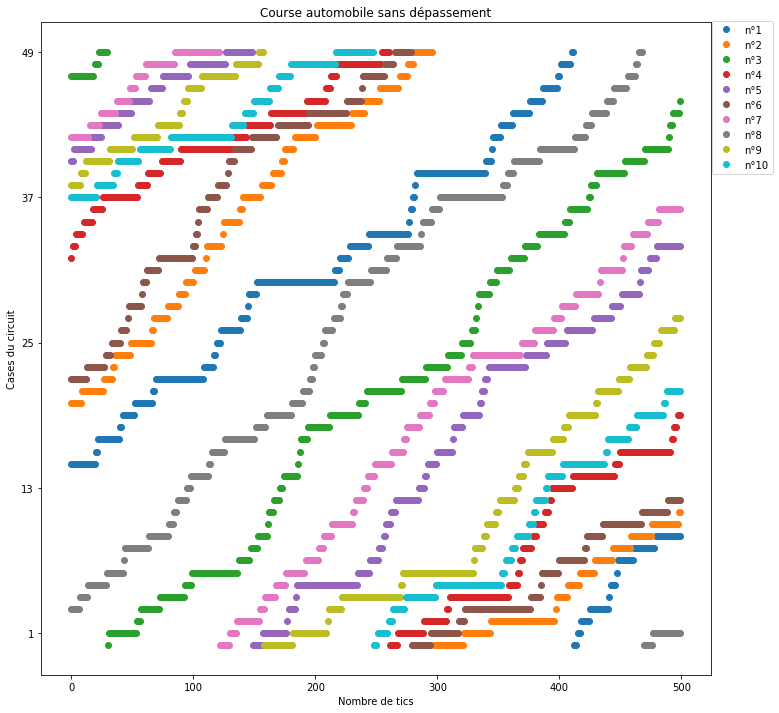

Fin de la course : 500 derniers tics


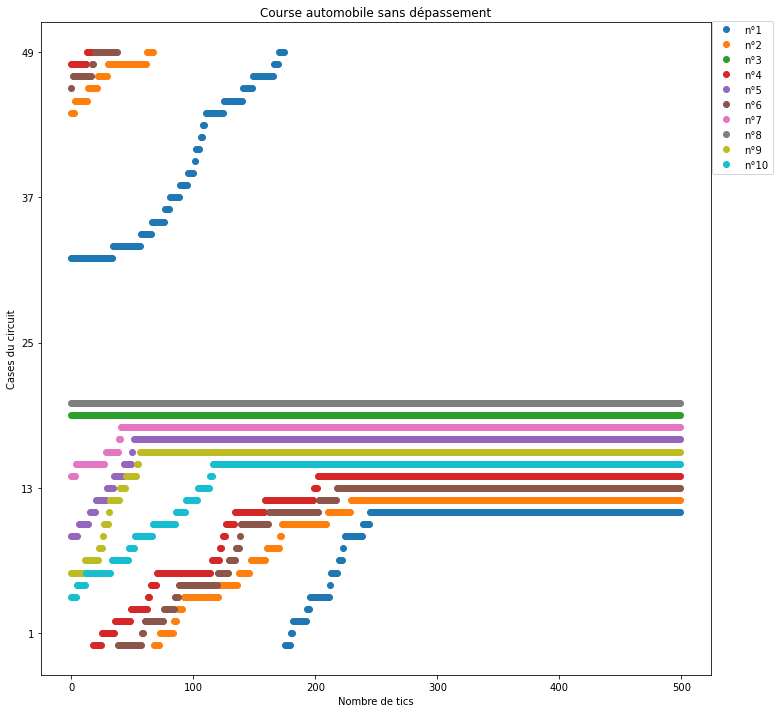

In [11]:
seed(14)
N1 = 50 # Nombre de cases du circuit
n1 = 10 # Nombre de véhicules du circuit
k1 = 1000 # Nombre de tics par horloges

circuit3,M2 = representation_deplacement_voitures(circuit(N1,n1),ordre_deplacement(n1,k1),n1,k1)

plt.figure(figsize=(12,12))
print("Départ de la course : 500 derniers tics")
for i in range(n1):
    plt.plot(M2[i,0:500], label = "n°" + str(i+1), marker = "o",ls = '')
plt.yticks(np.arange(1,N1,int(N1/np.log(N1))))
plt.title("Course automobile sans dépassement")
plt.legend(bbox_to_anchor=(1.1, 1.01),loc='upper right')
plt.xlabel("Nombre de tics")
plt.ylabel("Cases du circuit")
plt.show()

print("Fin de la course : 500 derniers tics")
plt.figure(figsize=(12,12))
for i in range(n1):
    plt.plot(M2[i,9500:10000], label = "n°" + str(i+1), marker = "o",ls = '')
plt.yticks(np.arange(1,N1,int(N1/np.log(N1))))
plt.title("Course automobile sans dépassement")
plt.legend(bbox_to_anchor=(1.1, 1.01),loc='upper right')
plt.xlabel("Nombre de tics")
plt.ylabel("Cases du circuit")
plt.show()

La visualisation de ce graphique permet de confirmer que les véhicules ne se doublent pas, et que toutes les cases sont bien visitées.

Vu que les voitures n'ont pas le droit de se dépasser, lorsque qu'une voiture aura éffectué tous les tics de son horloges celle-ci va s'arreter créant un bouchon derrière elle.

## Création d'une vidéo 

Grâce au module cellulloid, on créer une vidéo qui montre le déplacement des voitures dans la course.  
Pour des soucis liés à l'animation sur Jupyter, on intègre directement le résultat dans le markdown sous le code.

In [12]:
# Code utilisé pour créer la vidéo
"""
from celluloid import Camera

seed(14)
N2 = 50 
n2 = 10
k2 = 100

circuit4,M3 = representation_deplacement_voitures(circuit(N2,n2),ordre_deplacement(n2,k2),n2,k2)

fig = plt.figure(figsize=(10,10))
plt.suptitle('Course sans dépassement')
plt.title("Simulation de course automobile")
plt.ylabel('Numéro des voitures')
plt.xlabel('Cases du circuit')

camera = Camera(fig)
for i in range(n2*k2):
    plt.scatter(M3[:,i],np.arange(1,n2+1), label = "n°" + str(i+1), marker = "o",s = 150 ,c = np.arange(1,n2+1))
    camera.snap()
animation = camera.animate(interval=10)
plt.close() # Ferme le plot vide 


# Décommenter cette partie pour télécharger la vidéo

print("Le téléchargement commence")
animation.save('Course auto sans depassement.gif', writer = 'pillow')
print("Téléchargement fini")
""";

## Représentation de la course sans dépassement sous forme de vidéo


In [13]:
from IPython.display import Image
Image(url='https://cdn.discordapp.com/attachments/763495637625864234/801102502489096252/Course_auto_sans_depassement.gif')

## Représentation du flux où on fait varier le nombre de voiture

Création d'une fonction pour représenter le flux moyen en fonction de la proportion des véhicules.  
On calculera aussi la droite de régression linéaire associé au flux moyen.

Cette dernière nous aidera à proposer une fonction polynomiale approximant le flux moyen.

In [14]:
def visu_flux(N,k):
    """ 
    Paramètres :
    - N = nombre de cases du circuit
    - k = nombre de tics par véhicule
        
    Output :
    - Affichage du flux moyen en fonction de la proportion des véhicules.
    - Affichage de la droite de régression linéaire associé.
    """

    L = np.zeros(N-1)
    for i in range(1,N):

        if(i % (2*(N/10)) == 0):
            print("affichage du flux :", 100*i/N,"%")

        flux = deplacement_voitures(circuit(N,i),ordre_deplacement(i,k))[1]
        L[i-1] = flux

    plt.figure(figsize=(10,10))
    plt.suptitle('Course sans dépassement')
    plt.title('Flux moyen pour k = '+str(k)+' tics')
    plt.xlabel('Proportion des véhicules')
    plt.ylabel('Flux Moyen')
    x = [i/N for i in range(1,N)]
    plt.plot(x,L,label="Flux")

    # Droite de régression linéaire
    a = np.cov(x,L)[0][1]/np.var(x)
    b = np.mean(L) - a * np.mean(x)
    y = [_*a + b for _ in x]
    print("Approximation de la droite : y = {} * x + {} ".format(a,b))
    plt.plot(x,y,label="Approximation : \n y = {} * x + {}".format(round(a,2),round(b,2)))
    plt.legend()
    plt.show()

affichage du flux : 20.0 %
affichage du flux : 40.0 %
affichage du flux : 60.0 %
affichage du flux : 80.0 %
Approximation de la droite : y = -0.01010642286973965 * x + 0.010029637112327395 


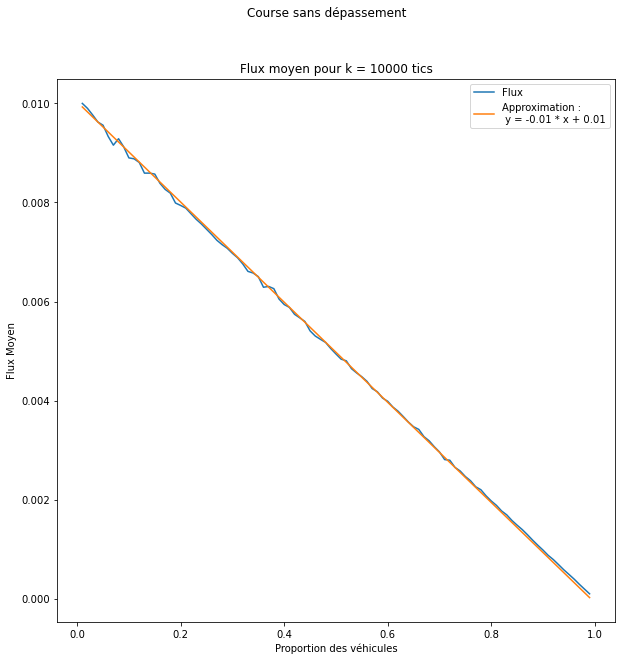

77.85050582885742


In [15]:
# Repésentation avec un nombre de cases plus petit 
t1 = time.time()
N1 = 100
visu_flux(N1,k)
print(time.time()-t1)

## Interprétation des résultats :

### Le flux est proportionnellement décroissant suivant la proportion des véhicules dans le circuit

Ce résultat est cohérent dans un modèle sans dépassement.  
On cherche à approximer le flux par une équation de droite affine.  

On cherche donc une droite y = ax + b où x représente la proportion des voitures dans le circuit   
On se place dans un modèle avec 10 000 tics et on va faire varier n.  

En pratique on obtient les résultats suivants :    

Pour n = 10 : ```y = - 0.12x + 0.12```   
Pour n = 50 : ```y = - 0.02x + 0.02```     
Pour n = 100 : ```y = - 0.01x + 0.01```   
Pour n = 1000 :  ```y = - 0.001x + 0.001```

### Suite à nos expérimentations, on propose $ y =  - \frac{1}{N}\cdot x\ + \frac{1}{N} $ comme équation pour le flux 

## Représentation flux où on fait varier le nombre de tics

On se place dans le modèle de base avec 500 cases et 10 véhicules, mais on va faire varier le nombre de tics pour interpréter les variations du flux possible. 

Chargement : 10000
Chargement : 20000
Chargement : 30000
Chargement : 40000
Chargement : 50000
Le flux moyen est de :  0.001954917697813987


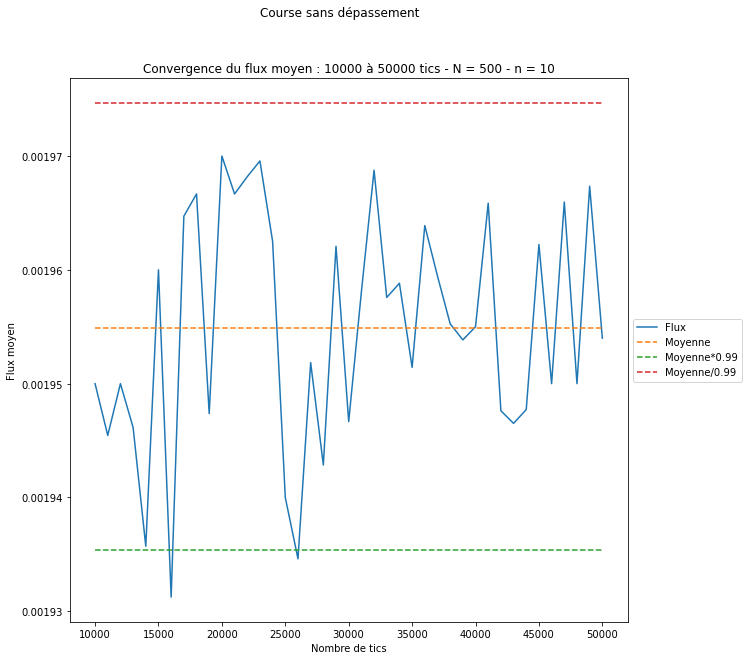

In [16]:
L = []
min = 10000
max = 50001
pas = 1000
for j in range(min,max,pas):
    if j % 10000 == 0:
        print("Chargement :", j)
    flux = deplacement_voitures(circuit(N, n), ordre_deplacement(n,j))[1]
    L.append(flux)
    
fig,ax = plt.subplots(figsize=(10,10))
plt.suptitle('Course sans dépassement')
plt.title('Convergence du flux moyen : 10000 à 50000 tics - N = '+ str(N) +' - n = '+ str(n))
plt.xlabel('Nombre de tics')
plt.ylabel('Flux moyen')

x = np.arange(min,max,pas)

plt.plot(x,L,label ='Flux')

moyenne = np.mean(L)
moyenne1 = [moyenne] * len(x)
moyenne2 = [moyenne*0.99] * len(x)
moyenne3 = [moyenne/0.99] * len(x)

ax.plot(x,moyenne1, label='Moyenne', linestyle='--')
ax.plot(x,moyenne2, label='Moyenne*0.99', linestyle='--')
ax.plot(x,moyenne3, label='Moyenne/0.99', linestyle='--')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

print("Le flux moyen est de : ", moyenne)
plt.show()

## Etude du comportement du flux. 

Pour un N et n fixé, on remarque qu'à partir d'un certain rang k, le flux ne dépend plus du nombre de tics k. 

Un nombre de tics suffisamment grand n'influence donc pas le flux et on observe moins de 1 % de variations à la moyenne.

On observe un flux moyen de 0.00198 quand N = 500 et n = 50.

## Comparons nos résultats avec des résultats théoriques :

Pour cela on calcule notre matrice de transition, puis la mesure invariante de notre chaine qui est unique car notre chaine est irréductible ( elle possède une seule classe de communication fermé ).

Tout d'abord, pour le modèle sans dépassement notre chaîne est défini comme suit :  

- La probabilité d'avancer d'une case est de : $ 1 - \frac{n-1}{N-1} $
- La probabilité de rester sur la même case est de : $ \frac{n-1}{N-1} $

Car il y a N-1 cases sans compter celle où est le véhicule et n-1 véhicules sans compter celui qui essaie d'avancer. 

### Création de la matrice de transition :

In [17]:
def matrice_transition(N, n):
    """ Renvoie la matrice de transition du circuit en fonction 
    du nombre de cases N et du nombres de voiture n """
    M = np.zeros((N,N))
    for i in range(N):
        M[i,i] = (n-1)/(N-1)
        M[i,(i+1)%N] = (N-n)/(N-1)
    return M

In [18]:
# Test
Q = matrice_transition(N,n)
Q

array([[0.01803607, 0.98196393, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01803607, 0.98196393, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01803607, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01803607, 0.98196393,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01803607,
        0.98196393],
       [0.98196393, 0.        , 0.        , ..., 0.        , 0.        ,
        0.01803607]])

## Calcul de la mesure invariante

In [19]:
def mesure_invariante(M):
    
    """ Calcule la mesure invariante de notre chaine """
 
    propre=np.linalg.eig(M.T)[1]
    
    propre1=propre[:,0]
    
    mu=abs(propre1)/sum(abs(propre1))
    
    return mu.T

In [20]:
# Test
mesure_invariante(Q)[0:10]

array([0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002])

Chaque véhicule passe donc 0.2 % de son temps sur chaque case.  


Ce qui nous donne une erreur relative de : $ \frac {0.002 -  0.00196}{0.002} = 0.02 = 2 \% $ par rapport au résultat trouvé.  
Confirmant la pertinence de nos algorithmes.

# <center> Modèle avec dépassement </center>
## Déplacement des voitures et calcul du flux

On modifie la fonction deplacement_voitures pour que les voitures aient une possibilité de se dépasser suivant des probabilités définies.

In [21]:
@nb.jit(('Tuple((int32[:],float64))(Tuple((int32[:],int32[:])) ,int32[:],float64[:])'),nopython = True)
def deplacement_voitures_depassement(circuit,deplacement,proba_depassement):
    
    """ 
    Paramètres :
    - circuit = couple( Etat du circuit , Emplacement des voitures )
    - deplacement = Ordre de déplacement des véhicules
    - proba_depassement = vecteur de probabilités de dépassement 
        
    Output :
    - Etat final du circuit avec les voitures une fois tous les déplacement éffectués.
    - Flux du circuit
    """
    
    flux = 0
    circuit2 = np.copy(circuit[0]) # Etat du circuit
    emplacement_voiture = np.copy(circuit[1]) # Emplacement des voitures
    
    Nbr_deplacement = len(deplacement) # Nbr_deplacement = nombre de tic * nombre de véhicule

    for i in range(Nbr_deplacement):
        
        depassement = True # On initialise a la valeur Vrai au cas ou il n'y ai personne devant nous au début
        case_depart = False
        
        j = 0
        # Recherche de la case de la voiture deplacement[i]
        case = emplacement_voiture[deplacement[i] - 1] 
        prochaine_case = (case + 1)%len(circuit2)
        
        while circuit2[prochaine_case] != 0 : # Tant que la prochaine case regardé n'est pas nulle

            u = rand()
            if proba_depassement[j] > rand():  # On essaie de dépasser
                depassement = True
                if prochaine_case == 1:
                    case_depart = True
                prochaine_case = (prochaine_case + 1)%len(circuit2) # Si on réussi, on regarde l'état de la case d'après
                j += 1
                
            else: # Si on échoue un des dépassements on ne bouge pas
                depassement = False
                case_depart = False
                break # On retourne au début de la boucle for

        if case_depart: # On augmente le flux si on a dépassé quelqu'un sur la case départ
             flux += 1
                
        # Si on a réussi a dépasser toutes les voitures devant nous ou qu'il ny a personne devant nous
        if depassement: 
            
            # On regarde si on passe par la case départ
            if prochaine_case == 1 : 
                flux += 1
                
            # On update l'état du circuit
            circuit2[prochaine_case] += circuit2[case]  # la voiture avance
            circuit2[case] = 0 # Donc il n'y a plus personne sur la case originale
            
            # On update l'emplacement des voitures
            emplacement_voiture[deplacement[i] - 1] = prochaine_case

    return circuit2,flux/Nbr_deplacement

In [22]:
# Test 
proba_depassement = np.array([0.5]* N)

circuit2,flux = deplacement_voitures_depassement(circuit(N,n),ordre_deplacement(n,k),proba_depassement)
print("Flux moyen :", flux)

Flux moyen : 0.002


## Représentation des déplacements des voitures

On modifie la fonction representation_deplacement_voitures pour que les voitures aient la possibilité de se dépasser suivant des probabilitées définies.

In [23]:
@nb.jit(('Tuple((int32[:],float64[:,:]))(Tuple((int32[:],int32[:])) ,int32[:],float64[:],int32,int32)'),nopython = True)
def representation_deplacement_voitures_depassement(circuit,deplacement,proba_depassement,n,k):
    
    """ 
    Paramètres :
    - circuit = couple( Etat du circuit , Emplacement des voitures )
    - deplacement = Ordre de déplacement des véhicules
    - proba_depassement = vecteur de probabilité de dépassement
    - n = nombre de véhicules
    - k = nombre de tics par véhicule
        
    Output :
    - Etat final du circuit avec les voitures une fois tous les déplacement éffectués.
    - Matrice représentant tous les déplacements des véhicules
    """

    circuit2 = np.copy(circuit[0]) # Etat du circuit
    emplacement_voiture = np.copy(circuit[1]) # Emplacement des voitures

    M = np.zeros((n,n*k)) # n ligne = nombres de voiture , n*k colonnes = toutes les cases qu'elles visitent

    M[:,0] = emplacement_voiture  # initialise la première de l'emplacement des voitures 

    Nbr_deplacement = len(deplacement)
    
    for i in range(Nbr_deplacement):
        
        depassement = True # On initialise a la valeur Vrai au cas ou il n'y ai personne devant nous au début
        case_depart = False

        if i%(2*Nbr_deplacement/10) == 0:
            print("Chargement :",100*i/Nbr_deplacement,"%")

        int_deplacement = int(deplacement[i])
        case = emplacement_voiture[int_deplacement - 1]

        # print("la voiture {} se trouve sur la case {} ".format(deplacement[i],case))

        prochaine_case = (case + 1)%len(circuit2)
        j = 0

        while circuit2[prochaine_case] != 0 : # Tant que la prochaine case regardé n'est pas nulle
            
            u = rand()

            if proba_depassement[j] > rand():  # On essaie de dépasser
                depassement = True
                if prochaine_case == 1:
                    case_depart = True
                prochaine_case = (prochaine_case + 1)%len(circuit2) # Si on réussi, on regarde l'état de la case d'après
                j += 1
                # print("prochaine case :",prochaine_case,"case depart",case_depart)


            else: # Si on échoue un des dépassements on ne bouge pas
                depassement = False
                case_depart = False
                break # On retourne au début de la boucle for


        if depassement: # Si on a réussi a dépasser toutes les voitures devant nous
            
            # On update le circuit
            circuit2[prochaine_case] += circuit2[case]  # la voiture avance
            circuit2[case] = 0 # Donc il n'y a plus personne sur la case originale
            
            # On update l'emplacement des voitures
            emplacement_voiture[int_deplacement - 1] = prochaine_case
            

        M[:,i] = emplacement_voiture

    return circuit2,M

In [24]:
#Test 
circuit2,M = representation_deplacement_voitures_depassement(circuit(N,n),ordre_deplacement(n,k),proba_depassement,n,k)
print("Matrice des déplacement où chaque ligne représente les cases visitées par une voiture : \n", M)

Chargement : 0.0 %
Chargement : 20.0 %
Chargement : 40.0 %
Chargement : 60.0 %
Chargement : 80.0 %
Matrice des déplacement où chaque ligne représente les cases visitées par une voiture : 
 [[344. 344. 344. ... 346. 347. 348.]
 [405. 405. 405. ... 410. 410. 410.]
 [185. 185. 185. ... 186. 186. 186.]
 ...
 [383. 383. 383. ... 397. 397. 397.]
 [ 35.  35.  35. ...  33.  33.  33.]
 [319. 320. 320. ... 299. 299. 299.]]


## Exemple d'une course avec dépassement
Pour la clarté des graphiques on choisit de plus petits paramètres.

Chargement : 0.0 %
Chargement : 20.0 %
Chargement : 40.0 %
Chargement : 60.0 %
Chargement : 80.0 %
Départ de la course : 500 premier tics


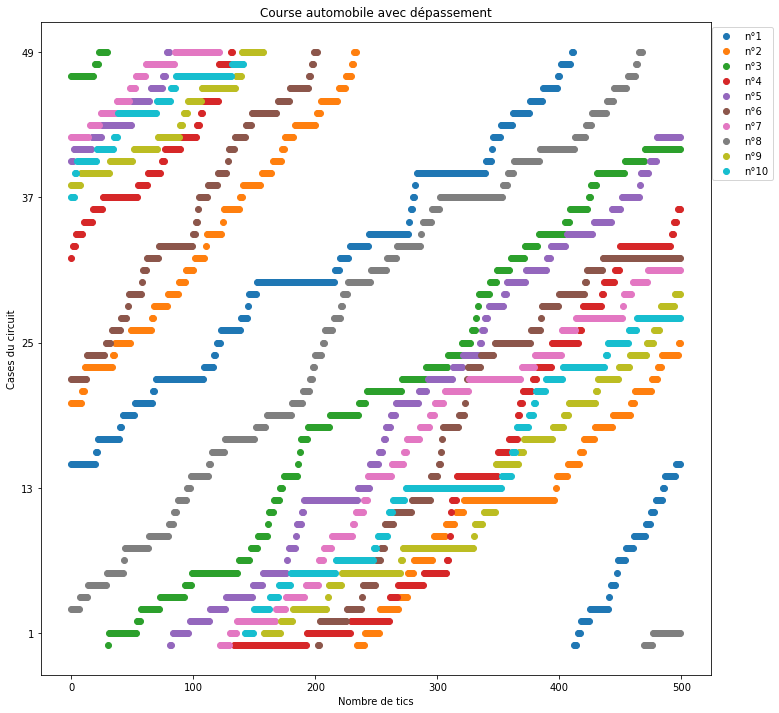

Fin de la course : 500 derniers tics


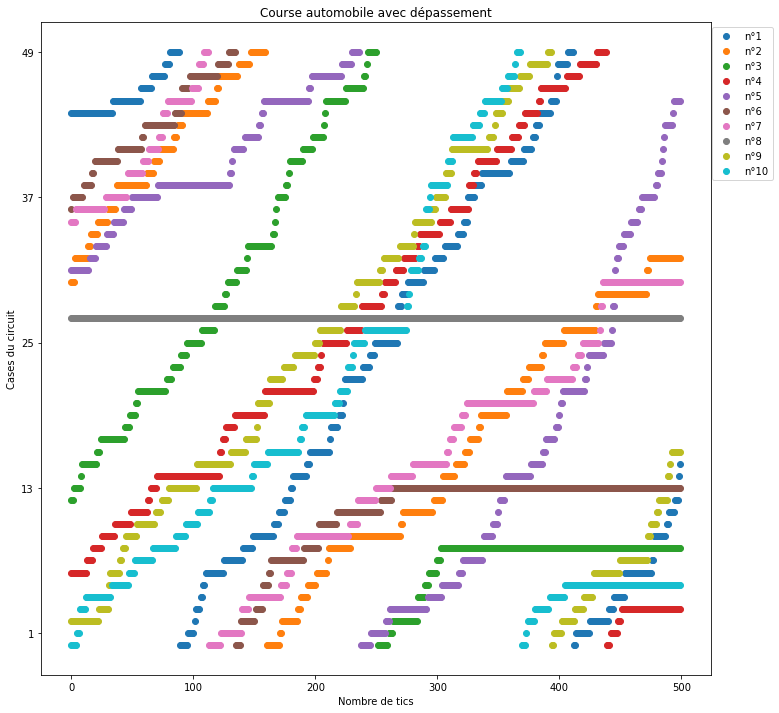

In [25]:
seed(14)
N1 = 50 # Nombre de cases du circuit
n1 = 10 # Nombre de véhicules du circuit
k1 = 1000 # Nombre de tics par horloges

circuit3,M2 = representation_deplacement_voitures_depassement(circuit(N1,n),ordre_deplacement(n,k1),proba_depassement,n,k1)

plt.figure(figsize=(12,12))
print("Départ de la course : 500 premier tics")
for i in range(n):
    plt.plot(M2[i,0:500], label = "n°" + str(i+1), marker = "o", ls = '')
plt.yticks(np.arange(1,N1,int(N1/np.log(N1))))
plt.title("Course automobile avec dépassement")
plt.legend(bbox_to_anchor=(1.1, 1),loc='upper right')
plt.xlabel("Nombre de tics")
plt.ylabel("Cases du circuit")
plt.show()

plt.figure(figsize=(12,12))
print("Fin de la course : 500 derniers tics")
for i in range(n):
    plt.plot(M2[i,9500:10000], label = "n°" + str(i+1), marker = "o", ls = '')
plt.yticks(np.arange(1,N1,int(N1/np.log(N1))))
plt.title("Course automobile avec dépassement")
plt.legend(bbox_to_anchor=(1.1, 1),loc='upper right')
plt.xlabel("Nombre de tics")
plt.ylabel("Cases du circuit")
plt.show()

Comparé au modèle sans depassement et malgrès le fait que la voiture grise se soit arrétés, la possibilité de se faire dépasser permet d'éviter la création d'un bouchon derrière elle.

In [26]:
# Code utilisé pour créer la vidéo
"""
from celluloid import Camera

seed(14)
N2 = 50 
n2 = 10
k2 = 100

circuit4,M3 = representation_deplacement_voitures_depassement(circuit(N2,n2),ordre_deplacement(n2,k2),proba_depassement,n2,k2)
fig = plt.figure(figsize=(10,10))
plt.suptitle('Course avec dépassement')
plt.title("Simulation de course automobile")
plt.ylabel('Numéro des voitures')
plt.xlabel('Cases du circuit')
camera = Camera(fig)
for i in range(n2*k2):
    plt.scatter(M3[:,i],np.arange(1,n2+1), label = "n°" + str(i+1), marker = "o",s = 150 ,c = np.arange(1,n2+1))
    camera.snap()
animation = camera.animate(interval=10)
plt.close()

# Décommenter cette partie pour télécharger la vidéo

print("Le téléchargement commence")
animation.save('Course auto avec dépassement.gif', writer = 'pillow')
print("Téléchargement fini")""";

## Représentation de la course avec dépassement sous forme de vidéo


In [27]:
from IPython.display import Image
Image(url='https://cdn.discordapp.com/attachments/763495637625864234/801101606220464138/Course_auto_avec_depassement.gif')

## Visualisation du flux 
Création d'une fonction pour représenter le flux moyen en fonction de la proportion des véhicules.

In [28]:
def visu_flux_depassement(N,proba_depassement,k):
    """ 
    Paramètres :
    - N = nombre de cases du circuit
    - proba_depassement = vecteur de probabilité de dépassement
    - k = nombre de tics par véhicule
        
    Output :
    - proportion des voitures
    - Liste des flux moyen en fonction de la proportion
    """
    L = np.zeros(N-1)
    for i in range(1,N):

        if(i % (2*(N/10)) == 0):
            print("affichage du flux :", 100*i/N,"%")

        flux = deplacement_voitures_depassement(circuit(N,i),ordre_deplacement(i,k),proba_depassement)[1]
        L[i-1] = flux
    x = [i/N for i in range(1,N)]
    return x , L 

## Etude du flux 

Affichons $4$ courses avec des probabilités de dépassement différentes pour visualiser le comportement des voitures.

On fixe ici le nombre de cases du circuit à $50$ et on fait varier la proportion des véhicules.   
On regarde le résultat pour des probabilités de dépassement de $0.2$, $0.4$, $0.6$ et $0.8$

Figure 1 / 4 :
affichage du flux : 20.0 %
affichage du flux : 40.0 %
affichage du flux : 60.0 %
affichage du flux : 80.0 %
Figure 2 / 4 :
affichage du flux : 20.0 %
affichage du flux : 40.0 %
affichage du flux : 60.0 %
affichage du flux : 80.0 %
Figure 3 / 4 :
affichage du flux : 20.0 %
affichage du flux : 40.0 %
affichage du flux : 60.0 %
affichage du flux : 80.0 %
Figure 4 / 4 :
affichage du flux : 20.0 %
affichage du flux : 40.0 %
affichage du flux : 60.0 %
affichage du flux : 80.0 %


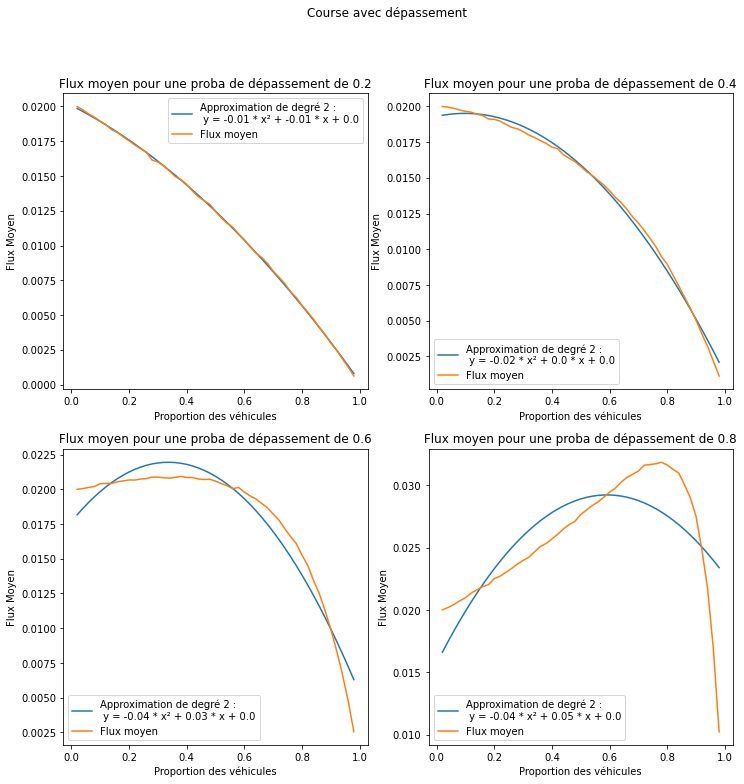

In [29]:
plt.figure(figsize = (12,12))
for i in range(4):
    print("Figure", i+1, "/ 4 :")
    proba_depassement = np.array([0.2*(i+1)] * 50)
    x0, L0 = visu_flux_depassement(50,proba_depassement,k)
    plt.subplot(2,2,i+1)
    plt.title('Flux moyen pour une proba de dépassement de '+ str(round(0.2*(i+1),1)))
    plt.suptitle('Course avec dépassement')
    plt.xlabel('Proportion des véhicules')
    plt.ylabel('Flux Moyen')
    mymodel = np.poly1d(np.polyfit(x0, L0, 2))
    plt.plot(x0, mymodel(x0),label="Approximation de degré 2 :\n y = {} * x² + {} * x + {}".format(round(mymodel[2],2),round(mymodel[1],2),round(mymodel[0]),2))
    plt.plot(x0,L0,label="Flux moyen")
    plt.legend()
plt.show()

## Interprétation des graphiques avec probabilité de dépassement constante

### Comparaison avec la proba de dépassement 
Pour les modèles ayant une probabilité constante de dépassement inférieur à 0.5 la flux moyen est décroissant peut importe la proportion des véhicules.  
Cependant pour les modèles ayant une probabilité constante de dépassement supérieur à 0.5, on remarque que le flux est croissant sur l'interval $[0,proba\_depassement]$ et décroissant sur l'interval $ ]proba\_depassement,1]$  


### Limite quand la proportion de véhicule tant vers 1
De plus quand la proportion de véhicules est assez faible, l'effet aléatoire produit de plus grandes variations du flux.

Mais de manière générale, une fois proportion de véhicules supérieur à la probabilité de dépassement, le flux diminue.  

Ce caractère est tout à fait normal vu que la probabilité de dépasser n véhicules d'affillés correspond à $ proba\_depassement^{n} $ et $ proba\_depassement < 1 \implies \lim\limits_{n\rightarrow\ + \infty}  proba\_depassement ^{n} = 0 $

Donc tant que l'on a une probabilité de dépassement strictement inférieur à 1 le flux convergera vers 0.

## Etude du flux moyen avec une probabiltié de dépassement variable

affichage du flux : 20.0 %
affichage du flux : 40.0 %
affichage du flux : 60.0 %
affichage du flux : 80.0 %


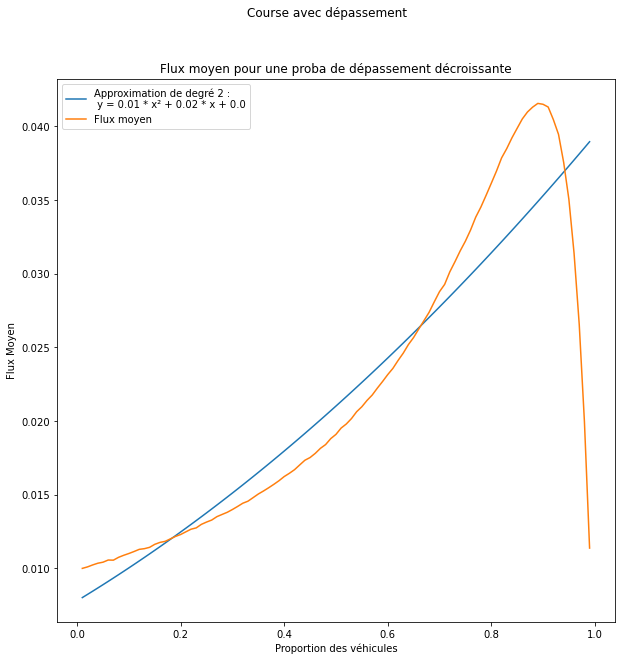

In [30]:
proba_depassement4 = np.linspace(1,0,100)
plt.figure(figsize=(10,10))
x4, L4 = visu_flux_depassement(100,proba_depassement4,k)
plt.title('Flux moyen pour une proba de dépassement décroissante')
plt.suptitle('Course avec dépassement')
plt.xlabel('Proportion des véhicules')
plt.ylabel('Flux Moyen')
mymodel = np.poly1d(np.polyfit(x4, L4, 2))
plt.plot(x4, mymodel(x4),label="Approximation de degré 2 :\n y = {} * x² + {} * x + {}".format(round(mymodel[2],2),round(mymodel[1],2),round(mymodel[0]),2))
plt.plot(x4,L4,label="Flux moyen")
plt.legend()
plt.show()

## Interprétation des graphiques avec probabilité de dépassement constante

### Comparaison avec la proba de dépassement 

Dans ce modèle la probabilité de dépassement est décroissante. Cela signifique qu'il est plus facile de dépasser une voiture que les voitures suivantes. 

On observe que le flux croit rapidement quand la proportion est dans l'interval $[0.3 , 0.8]$ et décroit très rapidement au dessus de 0.85.

Chargement:  10000
Chargement:  20000
Chargement:  30000
Chargement:  40000
Chargement:  50000
Le flux moyen est de : 0.002017626860822086


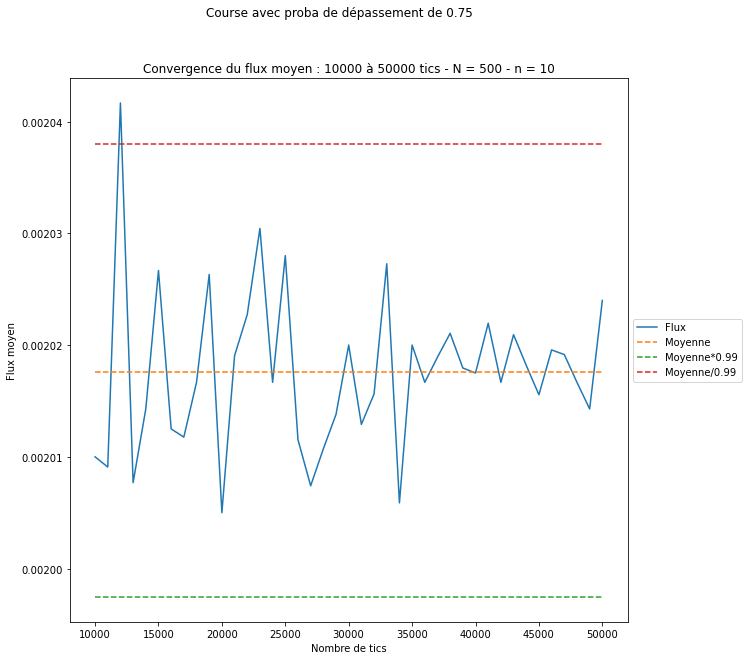

In [31]:
L = []
proba_depassement5 = np.array([0.75]*100)
min = 10000
max = 50001
pas = 1000
for j in range(min,max,pas):
    if j % 10000 == 0:
        print("Chargement: ", j)
    flux = deplacement_voitures_depassement(circuit(N, n), ordre_deplacement(n,j),proba_depassement5)[1]
    L.append(flux)
    
fig,ax = plt.subplots(figsize=(10,10))
plt.suptitle('Course avec proba de dépassement de 0.75')
plt.title('Convergence du flux moyen : 10000 à 50000 tics - N = '+str(N)+' - n = '+str(n))
plt.xlabel('Nombre de tics')
plt.ylabel('Flux moyen')

x = np.arange(min,max,pas)

plt.plot(x,L,label ='Flux')

moyenne = np.mean(L)
moyenne1 = [moyenne] * len(x)
moyenne2 = [moyenne*0.99] * len(x)
moyenne3 = [moyenne/0.99] * len(x)

ax.plot(x,moyenne1, label='Moyenne', linestyle='--')
ax.plot(x,moyenne2, label='Moyenne*0.99', linestyle='--')
ax.plot(x,moyenne3, label='Moyenne/0.99', linestyle='--')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
print("Le flux moyen est de :",moyenne)
plt.show()

Dans le modèle avec dépassement on remarque que le flux effectue plus de variations, ce qui est normal vu que le dépassement dépend du hasard.  

Le flux est aussi beaucoup plus important que dans le modèle sans dépassement, car les voitures se bloquent moins, et qu'en 1 seul tic une voiture peut avancer de plusieurs cases.

## Optimisation 

Nous avons décidé de changer le fondement de quelques algorithmes pour les vectoriser afin de réduire au maximum la complexité de celui-ci et ainsi réduire son temps d'éxécution.  
De plus, nous avons adapté nos fonctions pour pouvoir les accelérer grâce au module Numba ce qui nous permet encore de réduire son temps de compilation.

### Plus de détails 

Pour la fonction ordre_deplacement, nous utilisons une méthode mathématique ainsi qu'une méthode de tri plutot qu'une méthode de recherche de minimum en boucle afin de savoir l'ordre des véhicule à deplacer, ce qui nous a permis de reduire drastiquement le temps de compilation.

De plus pour rechercher l'emplacement des véhicules nous utilisions la fonction np.where en boucle, ce qui faisait que notre projet total tournait en environ 15 minutes.

Pour améliorer ça, nous avons rajouté un vecteur des emplacements des voitures afin de ne plus avoir chercher l'emplacment de la voiture à avancer à chaque éxécution.

Nous avons fini par donner de bons paramètres a Numba pour encore accélérer la compilation.

In [32]:
print("La durée d'éxécution totale de notre projet est de :", round(time.time()-temps_total,2),"secondes")

La durée d'éxécution totale de notre projet est de : 414.1 secondes
